# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [75]:
# import libraries
import pandas as pd
import json
from pyspark.sql import SparkSession
from pyspark.sql.types import IntegerType, TimestampType
from pyspark.sql.functions import isnan, when, count, col, udf, split, to_date, max, countDistinct, avg, date_format
from pyspark.sql import functions as sF
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sb
from functools import reduce
from pyspark.sql.functions import hour, from_unixtime, col, month, dayofweek

In [76]:

# create a Spark session
spark = SparkSession.builder \
    .master("local") \
    .config("spark.executor.memory", "8g") \
    .appName("Creating Features") \
    .getOrCreate()

stack_overflow_data = 'mini_sparkify_event_data.json'


# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [77]:
df = spark.read.json(stack_overflow_data)
df.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

In [78]:
print((df.count(), len(df.columns)))

(286500, 18)


In [79]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [80]:
df.head(1)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')]

In [81]:
test=df.toPandas()
test.head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30


We will check for null values and we will remove them so we can prepare our data for analysis

In [82]:
Dict_Null = {col:df.filter(df[col].isNull()).count() for col in df.columns}
Dict_Null

{'artist': 58392,
 'auth': 0,
 'firstName': 8346,
 'gender': 8346,
 'itemInSession': 0,
 'lastName': 8346,
 'length': 58392,
 'level': 0,
 'location': 8346,
 'method': 0,
 'page': 0,
 'registration': 8346,
 'sessionId': 0,
 'song': 58392,
 'status': 0,
 'ts': 0,
 'userAgent': 8346,
 'userId': 0}

In [83]:
df.filter(df['userId']=='').count()

8346

In [84]:
df.filter(df['sessionId']=='').count()

0

In [85]:
df_clean=df.where(df['userId'] != '')

In [86]:
df_clean.filter(df['userId']=='').count()

0

In [87]:
Dict_Null = {col:df_clean.filter(df_clean[col].isNull()).count() for col in df_clean.columns}
Dict_Null

{'artist': 50046,
 'auth': 0,
 'firstName': 0,
 'gender': 0,
 'itemInSession': 0,
 'lastName': 0,
 'length': 50046,
 'level': 0,
 'location': 0,
 'method': 0,
 'page': 0,
 'registration': 0,
 'sessionId': 0,
 'song': 50046,
 'status': 0,
 'ts': 0,
 'userAgent': 0,
 'userId': 0}

In [88]:
test=df_clean.where(df['artist'].isNull())
test=test.toPandas()
test.head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,None,Logged In,Colin,M,54,Freeman,None,paid,"Bakersfield, CA",PUT,Add to Playlist,1538173362000,29,None,200,1538352905000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,None,Logged In,Micah,M,84,Long,None,free,"Boston-Cambridge-Newton, MA-NH",GET,Roll Advert,1538331630000,8,None,200,1538353150000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
2,None,Logged In,Micah,M,86,Long,None,free,"Boston-Cambridge-Newton, MA-NH",PUT,Thumbs Up,1538331630000,8,None,307,1538353376000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
3,None,Logged In,Alexi,F,4,Warren,None,paid,"Spokane-Spokane Valley, WA",GET,Downgrade,1532482662000,53,None,200,1538354749000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:32.0) G...,54
4,None,Logged In,Alexi,F,7,Warren,None,paid,"Spokane-Spokane Valley, WA",PUT,Thumbs Up,1532482662000,53,None,307,1538355255000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:32.0) G...,54


In [89]:
test.nunique()

artist               0
auth                 2
firstName          189
gender               2
itemInSession      859
lastName           173
length               0
level                2
location           114
method               2
page                18
registration       224
sessionId         2292
song                 0
status               3
ts               49696
userAgent           56
userId             224
dtype: int64

In [90]:
# Convert the 'ts' column from milliseconds to seconds and cast to a timestamp
df_clean = df_clean.withColumn('tsDate', (col('ts') / 1000.0).cast(TimestampType()))

# Extract the date from the timestamp and create a new 'date' column
df_clean = df_clean.withColumn('date', to_date('tsDate'))

# Print out the first row of the cleaned dataframe for inspection
df_clean.take(1)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', tsDate=datetime.datetime(2018, 10, 1, 0, 1, 57), date=datetime.date(2018, 10, 1))]

In [91]:
# Split the 'location' column by ',' and create a new 'city' column with the first element
df_clean = df_clean.withColumn('city', split(df_clean['location'], ',')[0])

# Split the 'location' column by ',' and create a new 'state' column with the second element
df_clean = df_clean.withColumn('state', split(df_clean['location'], ',')[1])

# Drop the original 'location' column from the dataframe
df_clean = df_clean.drop('location')


In [92]:
df_clean.head()


Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', tsDate=datetime.datetime(2018, 10, 1, 0, 1, 57), date=datetime.date(2018, 10, 1), city='Bakersfield', state=' CA')

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

Text(0.5,1,"Count of 'page' logs")

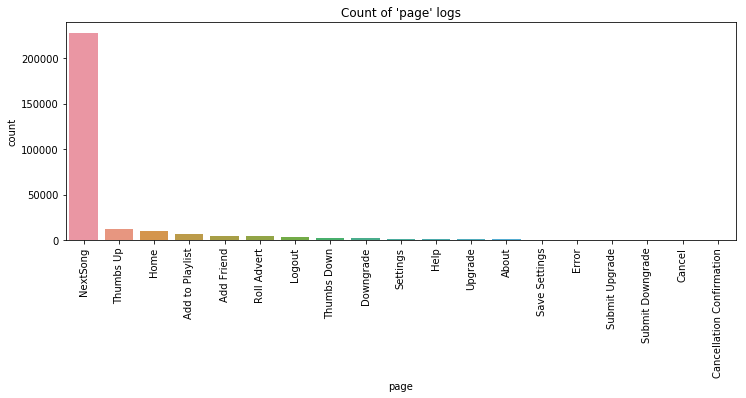

In [93]:
# Set the figure size of the plot to 12 inches wide by 4 inches tall
plt.figure(figsize = [12, 4])

# Select the 'page' column from the cleaned dataframe and convert to a Pandas dataframe
df = df_clean.select('page').toPandas()

# Create a count plot of the 'page' column using Seaborn's countplot() function
# Order the bars by the count of each category in descending order
sb.countplot(data = df, x = 'page', order = df['page'].value_counts().index)

# Rotate the x-axis labels by 90 degrees for better visibility
plt.xticks(rotation = 90)

# Set the title of the plot
ax = plt.gca()
ax.set_title("Count of 'page' logs")


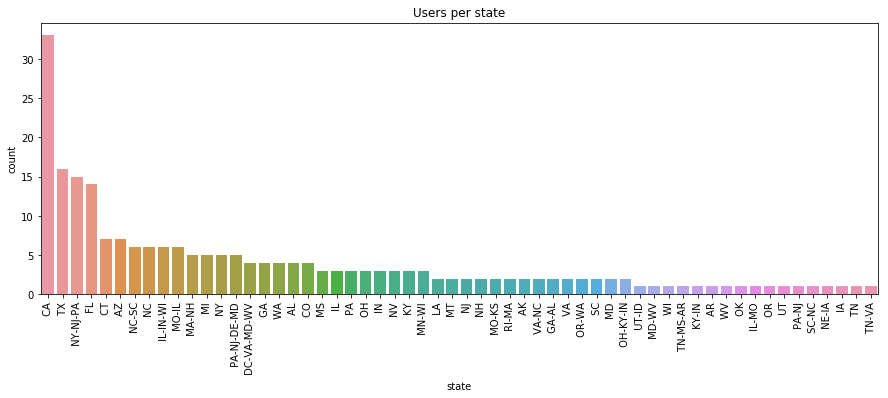

In [94]:
# Select the 'userId' and 'state' columns from the cleaned dataframe, drop duplicates, and convert to a Pandas dataframe
df = df_clean.select('userId', 'state').dropDuplicates().toPandas()

# Set the figure size of the plot to 15 inches wide by 5 inches tall
plt.figure(figsize = [15, 5])

# Order the x-axis categories by the count of each state in descending order
data_order = df['state'].value_counts().index

# Create a count plot of the 'state' column using Seaborn's countplot() function
# Order the bars by the count of each state in descending order
sb.countplot(data = df, x = 'state', order = data_order).set_title('Users per state')

# Rotate the x-axis labels by 90 degrees for better visibility
plt.xticks(rotation = 90)

# Display the plot
plt.show()


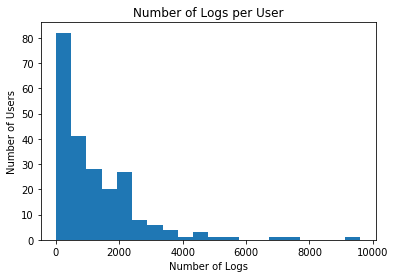

In [95]:
# Group the cleaned dataframe by 'userId', count the distinct 'ts' values for each user, and alias the resulting column as 'num_logs'
logs_per_user = df_clean.groupBy('userId').agg(countDistinct('ts').alias('num_logs'))

# Convert the resulting PySpark dataframe to a Pandas dataframe
logs_per_user_df = logs_per_user.toPandas()

# Create a histogram of the 'num_logs' column using Matplotlib's `hist()` function
# The `bins` parameter specifies the number of bins to use in the histogram
plt.hist(logs_per_user_df['num_logs'], bins=20)

# Set the title, x-axis label, and y-axis label of the plot
plt.title('Number of Logs per User')
plt.xlabel('Number of Logs')
plt.ylabel('Number of Users')

# Display the plot
plt.show()


In [96]:
cancelled = df_clean.where(df_clean.page == 'Cancellation Confirmation').select('userId').dropDuplicates()
cancelled.count()

52

In [97]:
downgraded = df_clean.where(df_clean.page == 'Submit Downgrade').select('userId').dropDuplicates()
downgraded.count()

49

In [98]:
downgraded.intersect(cancelled).count()


9

In [99]:
df_user_logs_cancelled = df_clean.where(df_clean.userId.isin([row.userId for row in cancelled.collect()])).groupby('userId').count().toPandas()

df_user_logs_downgraded = df_clean.where(df_clean.userId.isin([row.userId for row in downgraded.collect()])).groupby('userId').count().toPandas()

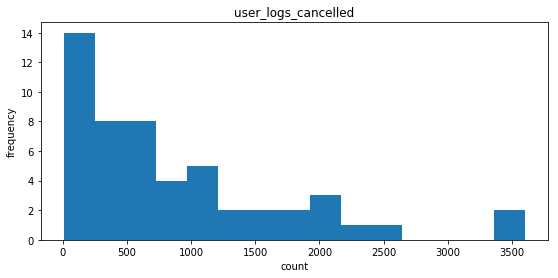

In [100]:
# Create a new Matplotlib figure with the specified size
fig = plt.figure(figsize = [12, 4])

# Create a new GridSpec with 1 row and 2 columns
spec = gridspec.GridSpec(ncols=2, nrows=1, width_ratios=[5, 1])

# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0.3)

# Create the first subplot in the first column of the GridSpec
ax0 = fig.add_subplot(spec[0])

# Create a histogram of the 'count' column from the 'df_user_logs_cancelled' dataframe with 15 bins
ax0.hist(df_user_logs_cancelled['count'], bins=15)

# Set the title of the plot
ax0.set_title('user_logs_cancelled')

# Set the x-axis and y-axis labels of the plot
plt.xlabel('count')
plt.ylabel('frequency')

# Display the plot
plt.show()

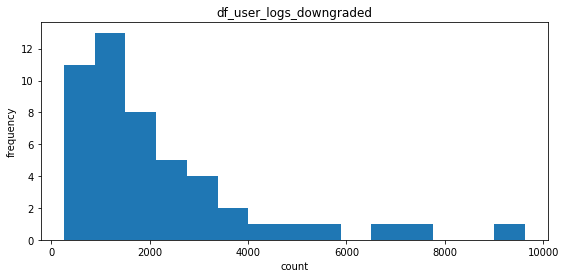

In [101]:
# Create a new Matplotlib figure with the specified size
fig = plt.figure(figsize = [12, 4])

# Create a new GridSpec with 1 row and 2 columns
spec = gridspec.GridSpec(ncols=2, nrows=1, width_ratios=[5, 1])

# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0.3)

# Create the first subplot in the first column of the GridSpec
ax0 = fig.add_subplot(spec[0])

# Create a histogram of the 'count' column from the 'df_user_logs_downgraded' dataframe with 15 bins
ax0.hist(df_user_logs_downgraded['count'], bins=15)

# Set the title of the plot
ax0.set_title('df_user_logs_downgraded')

# Set the x-axis and y-axis labels of the plot
plt.xlabel('count')
plt.ylabel('frequency')

# Display the plot
plt.show()


In [102]:
# Average number of songs listened per session
songs_per_session = df_clean.groupBy('userId', 'sessionId').agg(countDistinct('song').alias('num_songs'))
avg_songs_per_session = songs_per_session.groupBy('userId').agg(avg('num_songs').alias('avg_songs_per_session'))

# Filter for users who triggered 'Cancellation Confirmation' and 'Submit Downgrade' pages
cancel_users = df_clean.filter(df_clean.page == 'Cancellation Confirmation').select('userId').distinct().rdd.flatMap(lambda x: x).collect()
downgrade_users = df_clean.filter(df_clean.page == 'Submit Downgrade').select('userId').distinct().rdd.flatMap(lambda x: x).collect()

cancel_avg_songs = avg_songs_per_session.filter(avg_songs_per_session.userId.isin(cancel_users))
downgrade_avg_songs = avg_songs_per_session.filter(avg_songs_per_session.userId.isin(downgrade_users))

# Print results
print('Average number of songs listened per session for users who triggered "Cancellation Confirmation":', cancel_avg_songs.select('avg_songs_per_session').collect()[0][0])
print('Average number of songs listened per session for users who triggered "Submit Downgrade":', downgrade_avg_songs.select('avg_songs_per_session').collect()[0][0])


Average number of songs listened per session for users who triggered "Cancellation Confirmation": 8.0
Average number of songs listened per session for users who triggered "Submit Downgrade": 75.62162162162163


As we can see from the above results the users how downgraded and canceled do not have similar behavior so we
cannot put them in the same category "churn"

In [103]:
# Get a list of userIds for users who cancelled their service
cancelled_uids = [row.userId for row in cancelled.collect()]

# Define a UDF that returns 1 if a userId is in the list of cancelled userIds, and 0 otherwise
set_churn = udf(lambda x: 1 if x in cancelled_uids else 0, IntegerType())

# Add a new column 'churn' to the 'df_clean' dataframe, which contains the result of applying the 'set_churn' UDF to the 'userId' column
df_clean = df_clean.withColumn('churn', set_churn('userId'))

# Compute and display summary statistics for the 'churn' column using the 'describe()' method
df_clean.describe('churn').show()


+-------+-------------------+
|summary|              churn|
+-------+-------------------+
|  count|             278154|
|   mean|0.16129194618808287|
| stddev|0.36780068056308973|
|    min|                  0|
|    max|                  1|
+-------+-------------------+



In [104]:
df_clean.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', tsDate=datetime.datetime(2018, 10, 1, 0, 1, 57), date=datetime.date(2018, 10, 1), city='Bakersfield', state=' CA', churn=0)

In [105]:
df_clean.dropDuplicates(["userId"]).groupby(["churn", "auth"]).count().sort("churn").show()

+-----+---------+-----+
|churn|     auth|count|
+-----+---------+-----+
|    0|Logged In|  173|
|    1|Logged In|   52|
+-----+---------+-----+



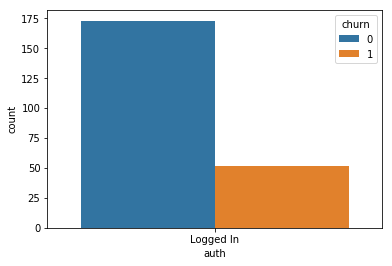

In [106]:
test = df_clean.dropDuplicates(["userId"]).groupby(["churn", "auth"]).count().sort("churn").toPandas()
sb.barplot(x="auth",y="count" ,hue="churn", data=test);

In [107]:
df_clean.dropDuplicates(["userId"]).groupby(["churn", "gender"]).count().sort("churn").show()

+-----+------+-----+
|churn|gender|count|
+-----+------+-----+
|    0|     M|   89|
|    0|     F|   84|
|    1|     F|   20|
|    1|     M|   32|
+-----+------+-----+



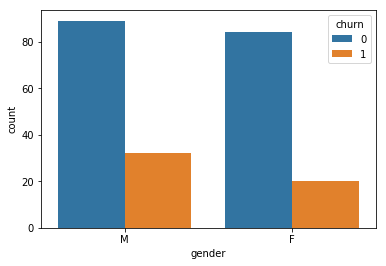

In [108]:
test = df_clean.dropDuplicates(["userId"]).groupby(["churn", "gender"]).count().sort("churn").toPandas()
sb.barplot(x="gender",y="count" ,hue="churn", data=test);

In [109]:
df_clean.dropDuplicates(["userId"]).groupby(["churn", "level"]).count().sort("churn").show()

+-----+-----+-----+
|churn|level|count|
+-----+-----+-----+
|    0| free|  133|
|    0| paid|   40|
|    1| paid|    8|
|    1| free|   44|
+-----+-----+-----+



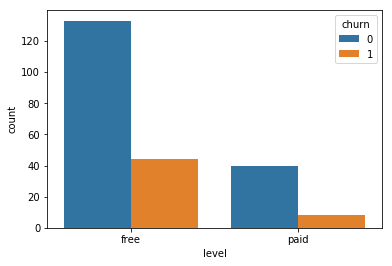

In [110]:
test = df_clean.dropDuplicates(["userId"]).groupby(["churn", "level"]).count().sort("churn").toPandas()
sb.barplot(x="level",y="count" ,hue="churn", data=test);

In [111]:
df_clean.dropDuplicates(["userId"]).groupby(["churn", "method"]).count().sort("churn").show()

+-----+------+-----+
|churn|method|count|
+-----+------+-----+
|    0|   GET|   88|
|    0|   PUT|   85|
|    1|   PUT|   25|
|    1|   GET|   27|
+-----+------+-----+



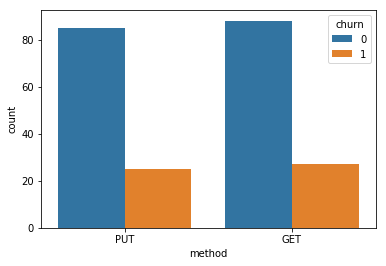

In [112]:
test = df_clean.dropDuplicates(["userId"]).groupby(["churn", "method"]).count().sort("churn").toPandas()
sb.barplot(x="method",y="count" ,hue="churn", data=test);

In [113]:

df_clean.select(["Churn", "page"]).groupby(["Churn", "page"]).count().sort("page").show()

+-----+--------------------+------+
|Churn|                page| count|
+-----+--------------------+------+
|    1|               About|    56|
|    0|               About|   439|
|    1|          Add Friend|   636|
|    0|          Add Friend|  3641|
|    1|     Add to Playlist|  1038|
|    0|     Add to Playlist|  5488|
|    1|              Cancel|    52|
|    1|Cancellation Conf...|    52|
|    0|           Downgrade|  1718|
|    1|           Downgrade|   337|
|    0|               Error|   220|
|    1|               Error|    32|
|    0|                Help|  1215|
|    1|                Help|   239|
|    0|                Home|  8410|
|    1|                Home|  1672|
|    1|              Logout|   553|
|    0|              Logout|  2673|
|    1|            NextSong| 36394|
|    0|            NextSong|191714|
+-----+--------------------+------+
only showing top 20 rows



In [114]:
test = df_clean.select(["page","Churn"]).groupby([ "page","Churn"]).count().sort("page").toPandas()
test.head()

,page,Churn,count
0,About,1,56
1,About,0,439
2,Add Friend,1,636
3,Add Friend,0,3641
4,Add to Playlist,1,1038


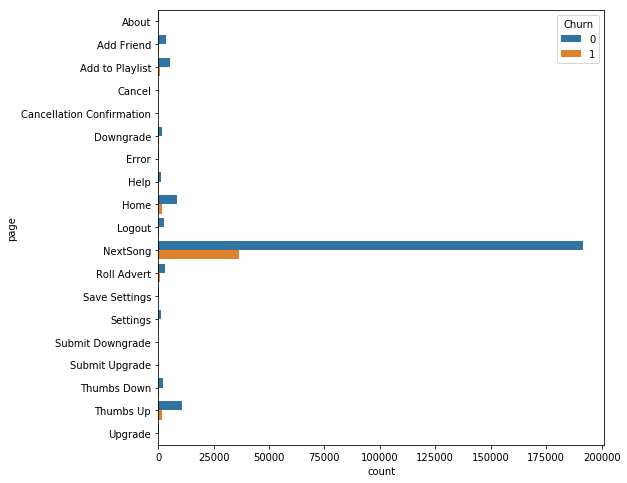

In [115]:
fig, ax = plt.subplots(figsize=(8,8))
sb.barplot( x="count",y="page", hue="Churn", data=test,ax=ax);

In [116]:
test = df_clean.select(["userId","Churn", "artist"]).groupby(["userId","Churn", "artist"]).count().sort("artist").toPandas()


In [117]:
test=test.drop(['artist'],1)
test.head()

,userId,Churn,count
0,19,0,43
1,100005,1,62
2,200007,0,11
3,300007,1,32
4,50,0,148


In [118]:
df = df_clean.toPandas()

In [119]:
df.head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,method,page,...,song,status,ts,userAgent,userId,tsDate,date,city,state,churn
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,PUT,NextSong,...,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,2018-10-01 00:01:57,2018-10-01,Bakersfield,CA,0
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,PUT,NextSong,...,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,2018-10-01 00:03:00,2018-10-01,Boston-Cambridge-Newton,MA-NH,0
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,PUT,NextSong,...,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,2018-10-01 00:06:34,2018-10-01,Bakersfield,CA,0
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,PUT,NextSong,...,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,2018-10-01 00:06:56,2018-10-01,Boston-Cambridge-Newton,MA-NH,0
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,PUT,NextSong,...,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,2018-10-01 00:11:16,2018-10-01,Bakersfield,CA,0


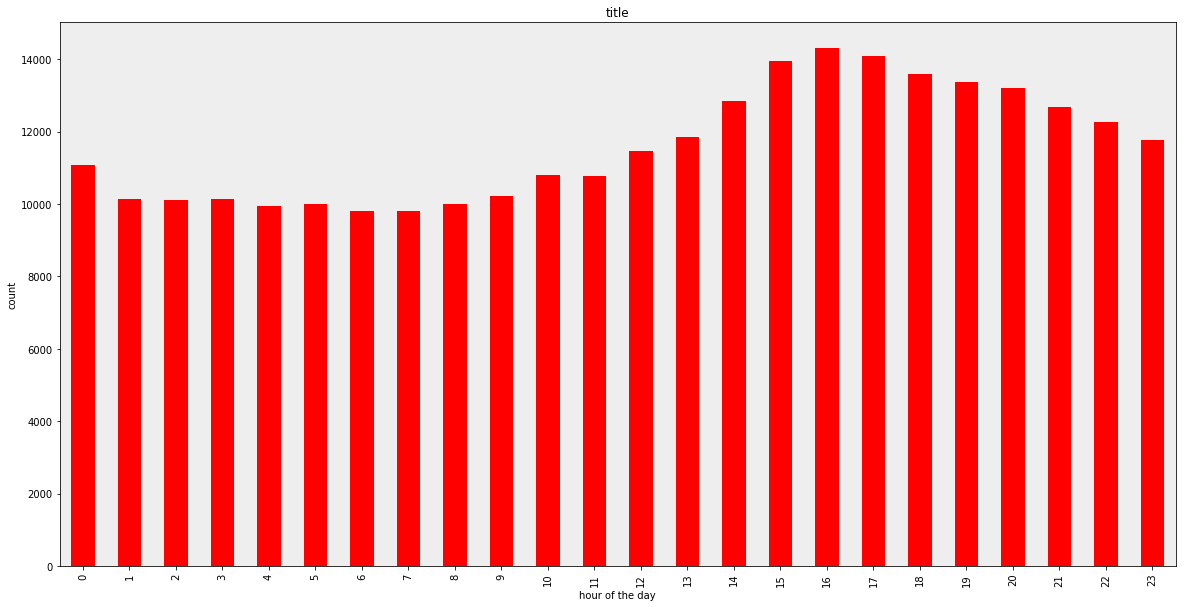

In [120]:
plt.figure(figsize=(20, 10))
ax = (df['tsDate'].groupby(df['tsDate'].dt.hour)
                     .count()).plot(kind="bar", color='red')
ax.set_facecolor('#eeeeee')
ax.set_xlabel("hour of the day")
ax.set_ylabel("count")
ax.set_title('title')
plt.show()

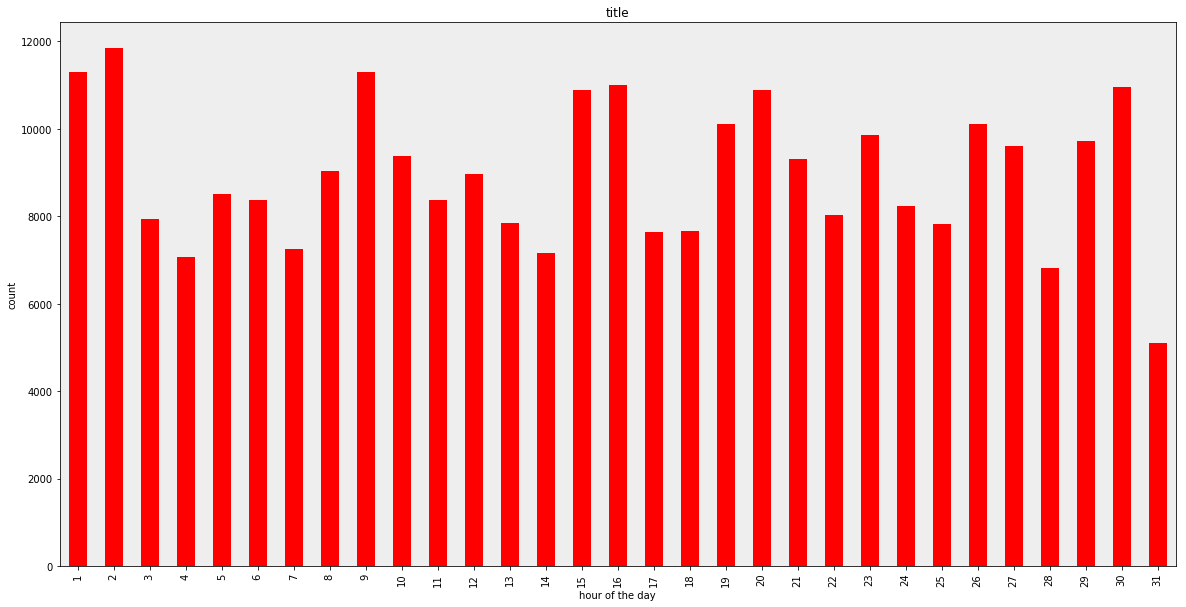

In [121]:
plt.figure(figsize=(20, 10))
ax = (df['tsDate'].groupby(df['tsDate'].dt.day)
                     .count()).plot(kind="bar", color='red')
ax.set_facecolor('#eeeeee')
ax.set_xlabel("hour of the day")
ax.set_ylabel("count")
ax.set_title('title')
plt.show()

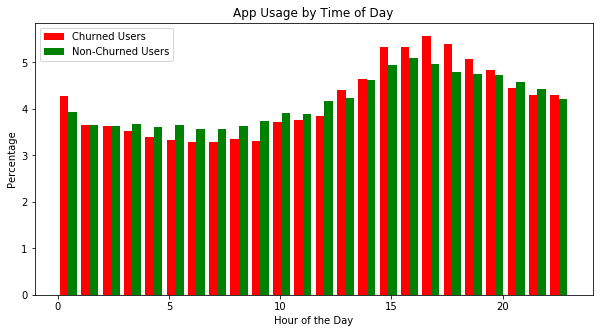

In [122]:
# create a new column with the hour of the day extracted from the timestamp
df = df_clean.withColumn("hour", hour(from_unixtime(col("ts") / 1000)))

# calculate the percentage of users who used the app during each hour of the day
churned_counts = df.filter(col("churn") == 1).groupBy("hour").count().withColumnRenamed("count", "churned_count")
total_churned = churned_counts.agg({"churned_count": "sum"}).collect()[0][0]
churned_counts = churned_counts.withColumn("churned_perc", churned_counts["churned_count"] / total_churned * 100)

non_churned_counts = df.filter(col("churn") == 0).groupBy("hour").count().withColumnRenamed("count", "non_churned_count")
total_non_churned = non_churned_counts.agg({"non_churned_count": "sum"}).collect()[0][0]
non_churned_counts = non_churned_counts.withColumn("non_churned_perc", non_churned_counts["non_churned_count"] / total_non_churned * 100)

# convert the PySpark dataframes to Pandas dataframes
churned_df = churned_counts.select("hour", "churned_perc").toPandas()
non_churned_df = non_churned_counts.select("hour", "non_churned_perc").toPandas()

# create a single histogram using matplotlib
fig, ax = plt.subplots(figsize=(10, 5))
ax.hist([churned_df["hour"], non_churned_df["hour"]], bins=24, color=['red', 'green'], label=['Churned Users', 'Non-Churned Users'], weights=[churned_df["churned_perc"], non_churned_df["non_churned_perc"]])

# set plot labels and title
ax.set_xlabel("Hour of the Day")
ax.set_ylabel("Percentage")
ax.set_title("App Usage by Time of Day")
ax.legend()

# display the plot
plt.show()

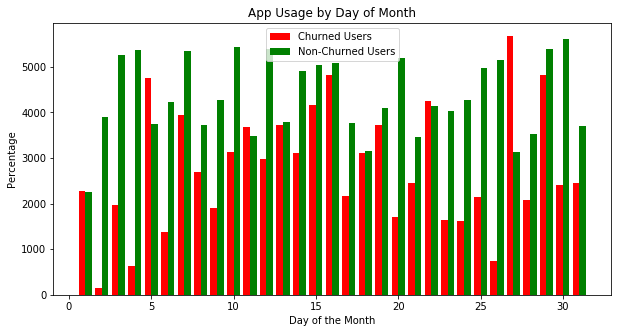

In [123]:
import numpy as np
from pyspark.sql.functions import dayofmonth
import seaborn as sns

# create a new column with the day of the month extracted from the timestamp
df = df_clean.withColumn("day", dayofmonth(from_unixtime(col("ts") / 1000)))

# calculate the percentage of churned and non-churned users who used the app on each day of the month
churned_counts = df.filter(col("churn") == 1).groupBy("day").agg(count("*").alias("churned_count"))
total_churned_users = df.filter(col("churn") == 1).agg(countDistinct("userId")).collect()[0][0]
churned_counts = churned_counts.withColumn("churned_pct", churned_counts["churned_count"] / total_churned_users * 100)

non_churned_counts = df.filter(col("churn") == 0).groupBy("day").agg(count("*").alias("non_churned_count"))
total_non_churned_users = df.filter(col("churn") == 0).agg(countDistinct("userId")).collect()[0][0]
non_churned_counts = non_churned_counts.withColumn("non_churned_pct", non_churned_counts["non_churned_count"] / total_non_churned_users * 100)

# convert the PySpark dataframes to two Pandas dataframes
churned_df = churned_counts.select("day", "churned_pct").toPandas()
non_churned_df = non_churned_counts.select("day", "non_churned_pct").toPandas()

# create a single histogram using matplotlib
fig, ax = plt.subplots(figsize=(10, 5))
bins = np.arange(1, 32)
width = 0.4
colors = sns.color_palette("Set2", n_colors=2)

ax.bar(bins - width/2, churned_df["churned_pct"], width=width, label="Churned Users", color='red')
ax.bar(bins + width/2, non_churned_df["non_churned_pct"], width=width, label="Non-Churned Users", color='green')

# set plot labels and title
ax.set_xlabel("Day of the Month")
ax.set_ylabel("Percentage")
ax.set_title("App Usage by Day of Month")
ax.legend()

# display the plot
plt.show()

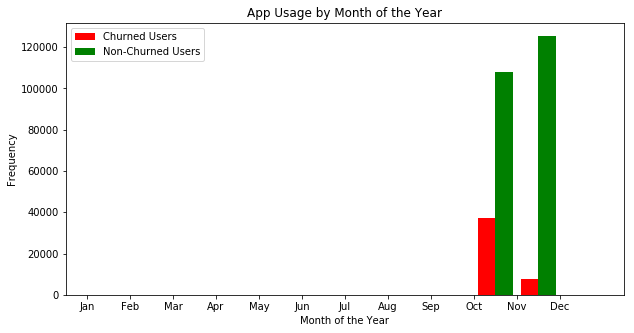

In [124]:
# create a new column with the month of the year extracted from the timestamp
df = df_clean.withColumn("month", month(from_unixtime(col("ts") / 1000)))

# convert the PySpark dataframe to two Pandas dataframes, one for churned users and one for non-churned users
churned_df = df.filter(col("Churn") == 1).select("month").toPandas()
non_churned_df = df.filter(col("Churn") == 0).select("month").toPandas()

# create a single histogram using matplotlib
fig, ax = plt.subplots(figsize=(10, 5))
ax.hist([churned_df["month"], non_churned_df["month"]], bins=12, range=(1, 13),  color=['red', 'green'], label=['Churned Users', 'Non-Churned Users'])

# set plot labels and title
ax.set_xlabel("Month of the Year")
ax.set_ylabel("Frequency")
ax.set_title("App Usage by Month of the Year")
ax.set_xticks(range(1, 13))
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
ax.legend()

# display the plot
plt.show()


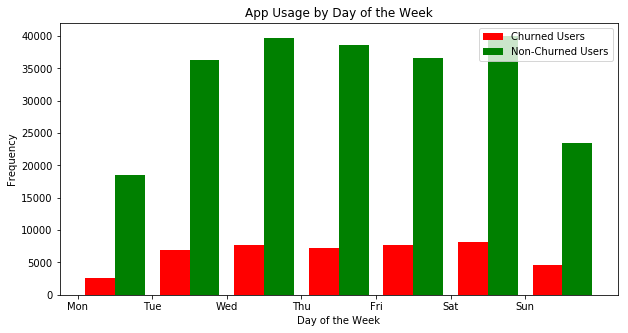

In [125]:
# create a new column with the day of the week extracted from the timestamp
df = df_clean.withColumn("day_of_week", dayofweek(from_unixtime(col("ts") / 1000)))

# convert the PySpark dataframe to two Pandas dataframes, one for churned users and one for non-churned users
churned_df = df.filter(col("Churn") == 1).select("day_of_week").toPandas()
non_churned_df = df.filter(col("Churn") == 0).select("day_of_week").toPandas()

# create a single histogram using matplotlib
fig, ax = plt.subplots(figsize=(10, 5))
ax.hist([churned_df["day_of_week"], non_churned_df["day_of_week"]], bins=7, range=(1, 8), color=['red', 'green'], label=['Churned Users', 'Non-Churned Users'])

# set plot labels and title
ax.set_xlabel("Day of the Week")
ax.set_ylabel("Frequency")
ax.set_title("App Usage by Day of the Week")
ax.set_xticks(range(1, 8))
ax.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
ax.legend()

# display the plot
plt.show()

# Feature Engineering

To predict user churn on a music app, we suggest the following features:

- User page distribution: captures user behavior and preferences
- Mean and standard deviation of songs: captures user engagement and activity
- Sessions count: measures user activity and usage
- Average songs per session: captures user engagement and behavior
- Total subscription days: measures user loyalty and commitment
- Gender: captures user demographics and preferences
- Level: captures user engagement and monetization potential
- Number of unique artists: measures user diversity and interests

Including these features in our model can help identify users at risk of churning and take actions to retain them.



In [126]:
churn_users = df_clean.select('userId', 'Churn').dropDuplicates()

# check
churn_users.show(5)

+------+-----+
|userId|Churn|
+------+-----+
|    19|    0|
|100005|    1|
|200007|    0|
|300007|    1|
|    50|    0|
+------+-----+
only showing top 5 rows



In [127]:
gender_users = df_clean.select('userId', 'gender').dropDuplicates()
gender_users = gender_users.withColumn("gender", when(gender_users.gender == "M",1)
                                 .when(gender_users.gender == "F",0)
                                 .when(gender_users.gender.isNull() ,1)
                                 .otherwise(gender_users.gender))
gender_users.show(5)
print((gender_users.count(), len(gender_users.columns)))

+------+------+
|userId|gender|
+------+------+
|    44|     0|
|    46|     0|
|    41|     0|
|    72|     0|
|300023|     0|
+------+------+
only showing top 5 rows

(225, 2)


In [128]:
level_users = df_clean.select('userId', 'level').dropDuplicates()
level_users = level_users.withColumn("level", when(level_users.level == "paid",1)
                                 .when(level_users.level == "free",0)
                                 .when(level_users.level.isNull() ,"1")
                                 .otherwise(level_users.level))
level_users = level_users.groupBy('userId').agg(max(col('level')).alias('level'))
level_users.sort('userId').show(5)
print((level_users.count(), len(level_users.columns)))


+------+-----+
|userId|level|
+------+-----+
|    10|    1|
|   100|    1|
|100001|    0|
|100002|    1|
|100003|    0|
+------+-----+
only showing top 5 rows

(225, 2)


In [139]:
df = df_clean.toPandas()

# The distribution of pages per user (FILLING NAN with 0)
user_page_distribution = df.groupby('userId')['page'].value_counts().unstack().fillna(0)

# Drop Cancel and Cancellation Confirmation columns
user_page_distribution = user_page_distribution.drop(columns=['Cancel', 'Cancellation Confirmation'])

# Normalize each row to sum to 1
user_page_distribution = user_page_distribution.div(user_page_distribution.sum(axis=1), axis=0)

# Convert counts to percentages
user_page_distribution = user_page_distribution.multiply(100)

# Rename columns
user_page_distribution.columns = [f'norm_{col}' for col in user_page_distribution.columns]

# Reset index
user_page_distribution = user_page_distribution.reset_index()
user_page_distribution_spark = spark.createDataFrame(user_page_distribution)

user_page_distribution_spark.head()

Row(userId='10', norm_About=0.25157232704402516, norm_Add Friend=1.509433962264151, norm_Add to Playlist=1.1320754716981132, norm_Downgrade=0.8805031446540881, norm_Error=0.0, norm_Help=0.12578616352201258, norm_Home=3.7735849056603774, norm_Logout=1.3836477987421385, norm_NextSong=84.65408805031447, norm_Roll Advert=0.12578616352201258, norm_Save Settings=0.12578616352201258, norm_Settings=0.8805031446540881, norm_Submit Downgrade=0.0, norm_Submit Upgrade=0.0, norm_Thumbs Down=0.5031446540880503, norm_Thumbs Up=4.654088050314465, norm_Upgrade=0.0)

In [131]:
# Count the number of unique artists listened to by each user
artist_count = df_clean.select('userId', 'artist').dropDuplicates().groupBy('userId').count().withColumnRenamed("count", "num_aritst")
artist_count.show(5)


+------+----------+
|userId|num_aritst|
+------+----------+
|100010|       253|
|200002|       340|
|   125|         9|
|    51|      1386|
|   124|      2233|
+------+----------+
only showing top 5 rows



In [132]:
# Filter the dataframe to only include rows where the 'page' column is 'NextSong'
song_user_df = df_clean.filter(df_clean.page == 'NextSong')

# Group the dataframe by 'userId' and 'sessionId', and count the number of occurrences
song_user_df = song_user_df.groupBy('userId', 'sessionId').count()

# Group the dataframe by 'userId', and calculate the average and standard deviation of the count of songs per session
song_user_df = song_user_df.groupBy('userId').agg(
    sF.avg('count').alias('mean_songs'), 
    sF.stddev('count').alias('stdev_songs')
)

# Replace any null values in the dataframe with 0
song_user_df = song_user_df.na.fill(0)

# Show the first 5 rows of the resulting dataframe
song_user_df.show(5)

+------+------------------+------------------+
|userId|        mean_songs|       stdev_songs|
+------+------------------+------------------+
|100010|39.285714285714285| 22.96166577663945|
|200002|              64.5|51.309843110264914|
|   125|               8.0|               0.0|
|    51|             211.1| 168.1483802413148|
|   124|145.67857142857142|137.40587446912284|
+------+------------------+------------------+
only showing top 5 rows



In [133]:
# Select the userId and sessionId columns, drop duplicate rows, and group by userId to count the number of sessions
sessions_count = df_clean.select(["userId", "sessionId"]).dropDuplicates().groupby(["userId"]).count()

# Rename the count column to sessions_count
sessions_count = sessions_count.withColumnRenamed('count', 'sessions_count')

# Show the first 5 rows of the DataFrame
sessions_count.show(5)

# Print the number of rows and columns in the DataFrame
print((sessions_count.count(), len(sessions_count.columns)))

+------+--------------+
|userId|sessions_count|
+------+--------------+
|100010|             7|
|200002|             6|
|   125|             1|
|    51|            10|
|   124|            29|
+------+--------------+
only showing top 5 rows

(225, 2)


In [134]:
songs_per_session = df_clean.groupby(['userId', 'sessionId']).count().groupby('userId').agg(avg('count').alias('average_songs_per_session'))

# Now we can display the resulting dataframe
songs_per_session.show(5)
print((songs_per_session.count(), len(songs_per_session.columns)))

+------+-------------------------+
|userId|average_songs_per_session|
+------+-------------------------+
|100010|        54.42857142857143|
|200002|                     79.0|
|   125|                     11.0|
|    51|                    246.4|
|   124|        166.3793103448276|
+------+-------------------------+
only showing top 5 rows

(225, 2)


In [136]:
from pyspark.sql.functions import col
# select the relevant columns and group by userId
df_sub = df_clean.select("userId", "registration", "ts") \
                 .groupBy("userId", "registration") \
                 .agg(max("ts").alias("last_ts"))

# calculate the total days of subscription for each user
df_sub = df_sub.withColumn("total_sub_days", ((col("last_ts") - col("registration")) / 86400000).cast("int"))
df_sub = df_sub.drop("last_ts", "registration")
# display the results
df_sub.show(5)
print((df_sub.count(), len(df_sub.columns)))

+------+--------------+
|userId|total_sub_days|
+------+--------------+
|200024|            28|
|200025|           116|
|   118|            63|
|    28|            44|
|100003|            22|
+------+--------------+
only showing top 5 rows

(225, 2)


In [137]:
# Joining all the individual dataframes to create the final dataset
final_dataset = churn_users.join(gender_users,"userId", how='inner').dropDuplicates()
final_dataset = final_dataset.join(level_users,"userId", how='inner').dropDuplicates()
final_dataset = final_dataset.join(user_page_distribution_spark,"userId", how='inner').dropDuplicates()
final_dataset = final_dataset.join(artist_count,"userId", how='inner').dropDuplicates()
final_dataset = final_dataset.join(sessions_count,"userId", how='inner').dropDuplicates()
final_dataset = final_dataset.join(song_user_df,"userId", how='inner').dropDuplicates()
final_dataset = final_dataset.join(songs_per_session,"userId", how='inner').dropDuplicates()
final_dataset = final_dataset.join(df_sub,"userId", how='inner').dropDuplicates()

# Printing the schema of the final dataset to verify the column names and types
final_dataset.printSchema()


root
 |-- userId: string (nullable = true)
 |-- Churn: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- level: string (nullable = true)
 |-- norm_About: double (nullable = true)
 |-- norm_Add Friend: double (nullable = true)
 |-- norm_Add to Playlist: double (nullable = true)
 |-- norm_Downgrade: double (nullable = true)
 |-- norm_Error: double (nullable = true)
 |-- norm_Help: double (nullable = true)
 |-- norm_Home: double (nullable = true)
 |-- norm_Logout: double (nullable = true)
 |-- norm_NextSong: double (nullable = true)
 |-- norm_Roll Advert: double (nullable = true)
 |-- norm_Save Settings: double (nullable = true)
 |-- norm_Settings: double (nullable = true)
 |-- norm_Submit Downgrade: double (nullable = true)
 |-- norm_Submit Upgrade: double (nullable = true)
 |-- norm_Thumbs Down: double (nullable = true)
 |-- norm_Thumbs Up: double (nullable = true)
 |-- norm_Upgrade: double (nullable = true)
 |-- num_aritst: long (nullable = false)
 |-- sessions_count

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [67]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# Create a SparkSession
spark = SparkSession.builder.appName("ChurnPrediction").getOrCreate()

# Load the dataset into a PySpark DataFrame
df = final_dataset

# Split the dataset into training and test datasets
(training_data, test_data) = df.randomSplit([0.7, 0.3], seed=42)

# Assemble the feature vector
assembler = VectorAssembler(inputCols=['About', 'Add Friend', 'Add to Playlist', 'Downgrade', 'Error', 'Help', 'Home', 'Logout', 'NextSong', 'Roll Advert', 'Save Settings', 'Settings', 'Submit Downgrade', 'Submit Upgrade', 'Thumbs Down', 'Thumbs Up', 'Upgrade', 'num_aritst', 'sessions_count', 'mean_songs', 'stdev_songs','total_sub_days'], outputCol='features')
training_data = assembler.transform(training_data).select('features', 'Churn')
test_data = assembler.transform(test_data).select('features', 'Churn')

# Create an evaluator for model performance evaluation
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="Churn")

# Create a logistic regression model
lr = LogisticRegression(featuresCol='features', labelCol='Churn', maxIter=10)

# Create a parameter grid to search over
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01, 0.1, 1]) \
    .addGrid(lr.elasticNetParam, [0, 0.5, 1]) \
    .build()

# Create a 5-fold CrossValidator
crossval = CrossValidator(estimator=lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5)

# Fit the model with CrossValidator
cvModel = crossval.fit(training_data)

# Use the best model to make predictions on the test dataset
predictions = cvModel.transform(test_data)

# Evaluate the performance of the best model using binary classification evaluator
areaUnderROC = evaluator.evaluate(predictions)
print("Area Under ROC: " + str(areaUnderROC))

# Evaluate the performance of the best model using multiclass classification evaluator
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="Churn")
evaluator.setMetricName("accuracy")
accuracy = evaluator.evaluate(predictions)
print("Accuracy: " + str(accuracy))

evaluator.setMetricName("weightedPrecision")
precision = evaluator.evaluate(predictions)
print("Precision: " + str(precision))

evaluator.setMetricName("weightedRecall")
recall = evaluator.evaluate(predictions)
print("Recall: " + str(recall))

evaluator.setMetricName("f1")
f1_score = evaluator.evaluate(predictions)
print("F1 Score: " + str(f1_score))

Area Under ROC: 0.7676630434782605
Accuracy: 0.7419354838709677
Precision: 0.5504682622268471
Recall: 0.7419354838709677
F1 Score: 0.6320191158900836


In [64]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Create a SparkSession
spark = SparkSession.builder.appName("ChurnPrediction").getOrCreate()

# Load the dataset into a PySpark DataFrame
df = final_dataset

# Split the dataset into training and test datasets
(training_data, test_data) = df.randomSplit([0.7, 0.3], seed=42)

# Assemble the feature vector
assembler = VectorAssembler(inputCols=['About', 'Add Friend', 'Add to Playlist', 'Downgrade', 'Error', 'Help', 'Home', 'Logout', 'NextSong', 'Roll Advert', 'Save Settings', 'Settings', 'Submit Downgrade', 'Submit Upgrade', 'Thumbs Down', 'Thumbs Up', 'Upgrade', 'num_aritst', 'sessions_count', 'mean_songs', 'stdev_songs','total_sub_days'], outputCol='features')
training_data = assembler.transform(training_data).select('features', 'Churn')
test_data = assembler.transform(test_data).select('features', 'Churn')

# Train a Random Forest Classifier with parameter tuning
rf = RandomForestClassifier(featuresCol='features', labelCol='Churn')
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [5, 10, 20]) \
    .addGrid(rf.maxDepth, [3, 5, 7]) \
    .build()
crossval = CrossValidator(estimator=rf,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="Churn"),
                          numFolds=5)
cvModel = crossval.fit(training_data)
rf_model = cvModel.bestModel

# Use the trained model to make predictions on the test dataset
predictions = rf_model.transform(test_data)

# Evaluate the performance of the model using binary classification evaluator
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="Churn")
areaUnderROC = evaluator.evaluate(predictions)

# Print the area under ROC
print("Area Under ROC: " + str(areaUnderROC))

# Evaluate the performance of the model using multiclass classification evaluator
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="Churn")
evaluator.setMetricName("accuracy")
accuracy = evaluator.evaluate(predictions)

# Print the accuracy
print("Accuracy: " + str(accuracy))

# Print the precision, recall, and F1 score
evaluator.setMetricName("weightedPrecision")
precision = evaluator.evaluate(predictions)
print("Precision: " + str(precision))

evaluator.setMetricName("weightedRecall")
recall = evaluator.evaluate(predictions)
print("Recall: " + str(recall))

evaluator.setMetricName("f1")
f1_score = evaluator.evaluate(predictions)
print("F1 Score: " + str(f1_score))


Area Under ROC: 0.7350543478260868
Accuracy: 0.7419354838709677
Precision: 0.7060931899641577
Recall: 0.7419354838709677
F1 Score: 0.7092473118279571


In [65]:
# Create a SparkSession
spark = SparkSession.builder.appName("ChurnPrediction").getOrCreate()

# Load the dataset into a PySpark DataFrame
df = final_dataset

# Split the dataset into training and test datasets
(training_data, test_data) = df.randomSplit([0.7, 0.3], seed=42)

from pyspark.ml.feature import VectorAssembler
# Assemble the feature vector
assembler = VectorAssembler(inputCols=['About', 'Add Friend', 'Add to Playlist', 'Downgrade', 'Error', 'Help', 'Home', 'Logout', 'NextSong', 'Roll Advert', 'Save Settings', 'Settings', 'Submit Downgrade', 'Submit Upgrade', 'Thumbs Down', 'Thumbs Up', 'Upgrade', 'num_aritst', 'sessions_count', 'mean_songs', 'stdev_songs','total_sub_days'], outputCol='features')
training_data = assembler.transform(training_data).select('features', 'Churn')
test_data = assembler.transform(test_data).select('features', 'Churn')

# Create a decision tree classifier
from pyspark.ml.classification import DecisionTreeClassifier
dt = DecisionTreeClassifier(labelCol="Churn", featuresCol="features")

# Create a parameter grid to search over
from pyspark.ml.tuning import ParamGridBuilder
paramGrid = ParamGridBuilder() \
    .addGrid(dt.maxDepth, [5, 10, 15]) \
    .addGrid(dt.impurity, ['gini', 'entropy']) \
    .build()

# Create a 5-fold CrossValidator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="Churn")
evaluator.setMetricName("accuracy")
from pyspark.ml.tuning import CrossValidator
crossval = CrossValidator(estimator=dt,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5)

# Fit the model with CrossValidator
cvModel = crossval.fit(training_data)

# Use the best model to make predictions on the test dataset
predictions = cvModel.transform(test_data)

# Evaluate the performance of the best model using multiclass classification evaluator
accuracy = evaluator.evaluate(predictions)
print("Accuracy: " + str(accuracy))

evaluator.setMetricName("weightedPrecision")
precision = evaluator.evaluate(predictions)
print("Precision: " + str(precision))

evaluator.setMetricName("weightedRecall")
recall = evaluator.evaluate(predictions)
print("Recall: " + str(recall))

evaluator.setMetricName("f1")
f1_score = evaluator.evaluate(predictions)
print("F1 Score: " + str(f1_score))


Accuracy: 0.7096774193548387
Precision: 0.686236559139785
Recall: 0.7096774193548387
F1 Score: 0.6949884792626728


# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.

In [ ]:
from pyspark.sql import SparkSession

# Stop the SparkSession if it is already running
if 'spark' in locals():
    spark.stop()

# Create a new SparkSession
spark = SparkSession.builder.appName('myAppName').getOrCreate()